---
# AmpliGraph Tutorial 1
---
In this tutorial we will demonstrate how to use the AmpliGraph library. 

Things we will cover:

1. Exploration of a graph dataset
2. Splitting graph datasets into train and test sets
3. Training a model
4. Model selection and hyper-parameter search 
5. Saving and restoring a model
6. Evaluating a model
7. Using link prediction to discover unknown relations
8. Visualizing embeddings using Tensorboard

---

### Requirements:

A python environment with the AmpliGraph library installed. Please follow [the install guide](http://docs.ampligraph.org/en/latest/install.html).

In addition, you may want to install matplotlib and networkx to run some graph visualization code:

    pip install matplotlib networkx 

---


# 1. Dataset exploration

First things first! Lets import the required libraries and retrieve some data:

In [1]:
import ampligraph
import numpy as np
import pandas as pd

In this tutorial we're going to use the **`Nations`** graph dataset. Please note: this isn't the *greatest* dataset for demonstrating the power of knowledge graph embeddings, but is small, intuitive and should be familiar to most users. 

Run the following cell to pull down the dataset:

In [7]:
import io 
from zipfile import ZipFile
from urllib.request import urlopen

nations = pd.DataFrame()

resp = urlopen('https://s3-eu-west-1.amazonaws.com/ampligraph/datasets/nations.zip')
zipfile = ZipFile(io.BytesIO(resp.read()))
for fname in ['train', 'test', 'valid']:
    tmp = []
    for line in zipfile.open('nations/%s.txt' % fname).readlines():
        tmp.append(line.decode('utf-8'))
    
    nations = nations.append(pd.read_csv(io.StringIO('\n'.join(tmp)), delim_whitespace=True, header=None))

nations.columns = ['subject', 'predicate', 'object']
nations.reset_index(inplace=True, drop=True)

Successfully retrieved dataset!


Each data point is an triple in the form: 

    <subject, predicate, object>


In [3]:
nations.head(10)

,subject,predicate,object
0,netherlands,militaryalliance,uk
1,egypt,intergovorgs3,usa
2,jordan,relbooktranslations,usa
3,poland,timesincewar,ussr
4,uk,negativebehavior,ussr
5,poland,relintergovorgs,uk
6,usa,weightedunvote,india
7,china,accusation,india
8,uk,unweightedunvote,egypt
9,poland,embassy,netherlands


Let's list the subject and object entities found in the dataset:

In [7]:
entities = np.concatenate([nations['subject'], nations['object']])
print(np.unique(entities))

['brazil' 'burma' 'china' 'cuba' 'egypt' 'india' 'indonesia' 'israel'
 'jordan' 'netherlands' 'poland' 'uk' 'usa' 'ussr']


.. and all of the relationships that link them. Remember, these relationships only link *some* of the entities.

In [8]:
relations = nations['predicate']
print(relations.unique())

['militaryalliance' 'intergovorgs3' 'relbooktranslations' 'timesincewar'
 'negativebehavior' 'relintergovorgs' 'weightedunvote' 'accusation'
 'unweightedunvote' 'embassy' 'commonbloc1' 'commonbloc2' 'ngoorgs3'
 'exports3' 'economicaid' 'booktranslations' 'relexports' 'intergovorgs'
 'independence' 'reltreaties' 'ngo' 'blockpositionindex' 'relstudents'
 'aidenemy' 'eemigrants' 'officialvisits' 'unoffialacts' 'releconomicaid'
 'commonbloc0' 'expeldiplomats' 'relngo' 'students' 'nonviolentbehavior'
 'reldiplomacy' 'tourism' 'timesinceally' 'conferences' 'relexportbooks'
 'treaties' 'militaryactions' 'exportbooks' 'boycottembargo'
 'negativecomm' 'tourism3' 'reltourism' 'pprotests' 'emigrants3'
 'duration' 'attackembassy' 'dependent' 'violentactions' 'relemigrants'
 'warning' 'lostterritory' 'severdiplomatic']


## Visualizing graph data with NetworkX 

When working with graphs it's often useful (and even required) to visualize the data. Here, we're going to use the excellent [networkx](https://networkx.github.io/) library to display some of the relations found in our dataset. If you haven't installed NetworkX, or aren't interesting in generating visualizations right now then feel free to skip this section - it won't affect the rest of the tutorial. 

C:\Users\nicholas.mccarthy\miniconda3\envs\ampligraph\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


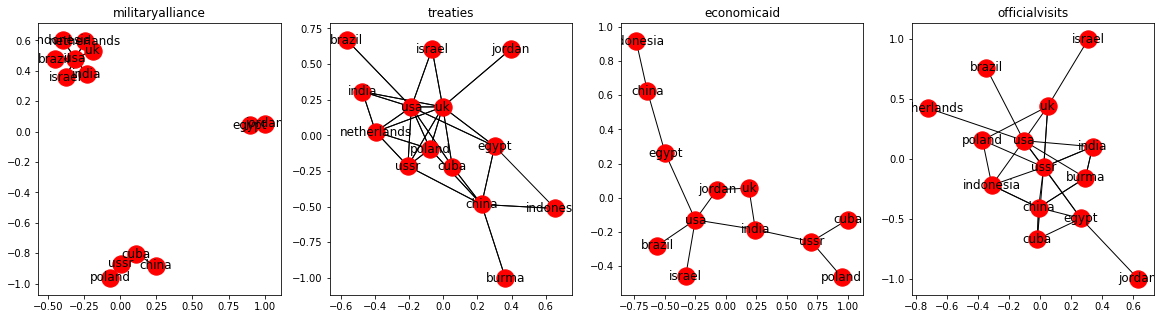

In [10]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for index, relation in enumerate(['militaryalliance', 'treaties', 'economicaid', 'officialvisits']):

    G = nx.MultiGraph()
    for i, row in nations.loc[nations['predicate'] == relation].iterrows():
        G.add_nodes_from([row[0], row[2]])
        G.add_edge(row[0], row[2], name=row[1])

    axs[index].set_title(relation)
    nx.draw_networkx(G, ax=axs[index])

# 2. Defining train and test datasets

As is typical in machine learning, we need to split our dataset into training and test (and sometimes validation) datasets. What differs from the standard method of randomly sampling N points to make up our test set, is that our data points are two entities linked by some relationship, and we need to take care to ensure that all entities are represented in train and test sets by at least 1 triple. To accomplish AmpliGraph provides the `train_test_split_no_unseen` function. 

We'll stick to common practice and divide our training and test set in an 80/20 split. 

In [11]:
from ampligraph.evaluation import train_test_split_no_unseen 

num_test = int(len(nations) * (20 / 100))

data = {}
data['train'], data['test'] = train_test_split_no_unseen(nations.values, test_size=num_test, seed=0, allow_duplication=False) 

Our data is now split into train/test sets. If we need to further divide into a validation dataset we can just repeat using the same procedure on the test set (and adjusting the split percentages). 

In [12]:
print('Train set size: ', data['train'].shape)
print('Test set size: ', data['test'].shape)

Train set size:  (1594, 3)
Test set size:  (398, 3)


---
# 3. Training a model 

AmpliGraph has implemented several Graph embedding models (TransE, ComplEx, DistMult, HolE), but to begin with we're just going to use the ComplEx model (with  default values), so lets import that:

In [13]:
from ampligraph.latent_features import ComplEx

Lets go through the parameters to understand what's going on:

- **`k`** : the dimensionality of the embedding space
- **`eta`** ($\eta$) : the number of negative, or false triples that must be generated at training runtime for each positive, or true triple
- **`batches_count`** : the number of batches in which the training set is split during the training loop. If you are having into low memory issues than settings this to a higher number may help.
- **`epochs`** : the number of epochs to train the model for.
- **`optimizer`** : the Adam optimizer, with a learning rate of 1e-3 set via the *optimizer_params* kwarg.
- **`loss`** : pairwise loss, with a margin of 0.5 set via the *loss_params* kwarg.
- **`regularizer`** : $L_p$ regularization with $p=2$, i.e. l2 regularization. $\lambda$ = 1e-5, set via the *regularizer_params* kwarg. 

Now we can instantiate the model:


In [14]:
model = ComplEx(batches_count=10, 
                seed=0, 
                epochs=200, 
                k=20, 
                eta=10,
                optimizer='adam', 
                optimizer_params={'lr':1e-3},
                loss='pairwise', 
                loss_params={'margin':0.5},
                regularizer='LP', 
                regularizer_params={'p':2, 'lambda':1e-5}, 
                verbose=True)

------ Loss-----
INFO - Name:pairwise
Name: pairwise
INFO - Parameters:
Parameters:
INFO - 	eta: 
   eta :  10
INFO - 	margin: 
   margin :  0.5
------ Regularizer-----
INFO - ------ Regularizer-----
Name: LP
INFO - Name:LP
Parameters:
INFO - Parameters:
INFO - 	lambda:1e-05

   lambda :  1e-05
INFO - 	p:2

   p :  2


## Filtering negatives

AmpliGraph aims to follow scikit-learn's ease-of-use design philosophy and simplify everything down to **`fit`**, **`evaluate`**, and **`predict`** functions. 

However, there are some knowledge graph specific steps we must take to ensure our model can be trained and evaluated correctly. The first of these is defining the filter that will be used to ensure that no *negative* statements generated by the corruption procedure are actually positives. This is simply done by concatenating our train and test sets. Now when negative triples are generated by the corruption strategy, we can check that they aren't actually true statements.  


In [17]:
positives_filter = np.concatenate((data['train'], data['test']))    

## Early stopping

We're also going to use early stopping to ensure we don't waste our valuable time (or GPU resources!). 

To train with early stopping we typically need a validation set, so let's revisit the `train_test_split_no_unseen` function from before, and divide the current test set in half to obtain a test and validation set. 

In [19]:
num_valid = len(data['test']) // 2
data['test'], data['valid'] = train_test_split_no_unseen(data['test'], test_size=num_valid, seed=0)

Let's take a look at some of the early stopping parameters:

- **`x_valid`** - specifies our validation set, so that we can test model performance on data we're not training on and stop at a good point
- **`criteria`** - the metric we'll use to measure model performance on the validation set. We specify here the 'hits10' criteria, which measures the amount of times the positive sample is found in the top 10 closest values when performing link prediction #TODO: Check this text
- **`burn_in`** - allows the model to train for a few epochs before early stopping kicks in
- **`check_interval`** - specifies how often the validation set should be evaluated for early stopping. 
- **`stop_interval`** - specifies how many validation set evaluations must be bad for early stopping to kick in. 
- **`x_filter`** - specifies the filter used to filter out the positives (we defined this above)
- **`corruption_entities`** - specifies the corruption strategy. Here we specify 'all' so corruptions are generated using all of the entitites.
- **`corrupt_side`** - specifies which end of the triple should be used for corruptions. Here we specify 's+o', so both subject and object are used for corruptions, but now at the same time.

Based on the burn_in, check_interval and stop_interval values we can see that the model will train for at least **n** epochs, where

    n = burn_in + (stop_interval * check_interval)  

In [20]:
early_stopping_params = { 'x_valid': data['valid'],    
                         'criteria':'hits10',
                         'burn_in': 100,
                         'check_interval':5,
                         'stop_interval':3,
                         'x_filter': positives_filter, 
                         'corruption_entities':'all',  
                         'corrupt_side':'s+o'          
                        }

We should now have a **`train`**, **`test`** and **`valid`** set, in an 80/10/10 split:


In [21]:
print('Train set size: ', data['train'].shape)
print('Test set size: ', data['test'].shape)
print('Valid set size: ', data['valid'].shape)

Train set size:  (1594, 3)
Test set size:  (100, 3)
Valid set size:  (99, 3)


## Fitting the model

Once you run the next cell the model will train. 

On the **`Nations`** dataset this shouldn't take too long: on an i7 CPU this was taking ~10secs before reaching early stopping, although your mileage may vary, especially if you've changed any of the parameters above. 

In [22]:
# Fit the model on training and validation set
model.fit(data['train'], 
          early_stopping = True,
          early_stopping_params = early_stopping_params
         )


WARNING - From C:\Users\nicholas.mccarthy\miniconda3\envs\ampligraph\lib\site-packages\tensorflow\python\framework\op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
INFO - Using all entities for generation of corruptions
['s+o']
WARNING - From C:\Users\nicholas.mccarthy\miniconda3\envs\ampligraph\lib\site-packages\tensorflow\python\ops\math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


  0%|          | 0/200 [00:00<?, ?epoch/s]

INFO - epoch: 1: mean loss:   0.499744


epoch: 1: mean loss:   0.499744


  0%|          | 1/200 [00:00<03:05,  1.07epoch/s]

INFO - epoch: 2: mean loss:   0.498775


epoch: 2: mean loss:   0.498775


  0%|          | 1/200 [00:00<03:05,  1.07epoch/s]

INFO - epoch: 3: mean loss:   0.496037


epoch: 3: mean loss:   0.496037


  2%|▏         | 3/200 [00:01<02:12,  1.49epoch/s]

INFO - epoch: 4: mean loss:   0.495207


epoch: 4: mean loss:   0.495207


  2%|▏         | 3/200 [00:01<02:12,  1.49epoch/s]

INFO - epoch: 5: mean loss:   0.494661


epoch: 5: mean loss:   0.494661


  2%|▎         | 5/200 [00:01<01:35,  2.05epoch/s]

INFO - epoch: 6: mean loss:   0.492997


epoch: 6: mean loss:   0.492997


  2%|▎         | 5/200 [00:01<01:35,  2.05epoch/s]

INFO - epoch: 7: mean loss:   0.492899


epoch: 7: mean loss:   0.492899


  4%|▎         | 7/200 [00:01<01:09,  2.78epoch/s]

INFO - epoch: 8: mean loss:   0.491220


epoch: 8: mean loss:   0.491220


  4%|▎         | 7/200 [00:01<01:09,  2.78epoch/s]

INFO - epoch: 9: mean loss:   0.489918


epoch: 9: mean loss:   0.489918


  4%|▍         | 9/200 [00:01<00:51,  3.69epoch/s]

INFO - epoch: 10: mean loss:   0.488133


epoch: 10: mean loss:   0.488133


  4%|▍         | 9/200 [00:01<00:51,  3.69epoch/s]

INFO - epoch: 11: mean loss:   0.485836


epoch: 11: mean loss:   0.485836


  6%|▌         | 11/200 [00:01<00:39,  4.78epoch/s]

INFO - epoch: 12: mean loss:   0.484796


epoch: 12: mean loss:   0.484796


  6%|▌         | 11/200 [00:01<00:39,  4.78epoch/s]

INFO - epoch: 13: mean loss:   0.483142


epoch: 13: mean loss:   0.483142


  6%|▋         | 13/200 [00:01<00:30,  6.16epoch/s]

INFO - epoch: 14: mean loss:   0.480589


epoch: 14: mean loss:   0.480589


  6%|▋         | 13/200 [00:01<00:30,  6.16epoch/s]

INFO - epoch: 15: mean loss:   0.479233


epoch: 15: mean loss:   0.479233


  8%|▊         | 15/200 [00:01<00:23,  7.74epoch/s]

INFO - epoch: 16: mean loss:   0.476869


epoch: 16: mean loss:   0.476869


  8%|▊         | 15/200 [00:01<00:23,  7.74epoch/s]

INFO - epoch: 17: mean loss:   0.473498


epoch: 17: mean loss:   0.473498


  8%|▊         | 17/200 [00:01<00:19,  9.35epoch/s]

INFO - epoch: 18: mean loss:   0.470322


epoch: 18: mean loss:   0.470322


  8%|▊         | 17/200 [00:01<00:19,  9.35epoch/s]

INFO - epoch: 19: mean loss:   0.467946


epoch: 19: mean loss:   0.467946


 10%|▉         | 19/200 [00:01<00:16, 10.88epoch/s]

INFO - epoch: 20: mean loss:   0.466135


epoch: 20: mean loss:   0.466135


 10%|▉         | 19/200 [00:02<00:16, 10.88epoch/s]

INFO - epoch: 21: mean loss:   0.462549


epoch: 21: mean loss:   0.462549


 10%|█         | 21/200 [00:02<00:14, 12.49epoch/s]

INFO - epoch: 22: mean loss:   0.458295


epoch: 22: mean loss:   0.458295


 10%|█         | 21/200 [00:02<00:14, 12.49epoch/s]

INFO - epoch: 23: mean loss:   0.454783


epoch: 23: mean loss:   0.454783


 10%|█         | 21/200 [00:02<00:14, 12.49epoch/s]

INFO - epoch: 24: mean loss:   0.450050


epoch: 24: mean loss:   0.450050


 12%|█▏        | 24/200 [00:02<00:12, 14.13epoch/s]

INFO - epoch: 25: mean loss:   0.445377


epoch: 25: mean loss:   0.445377


 12%|█▏        | 24/200 [00:02<00:12, 14.13epoch/s]

INFO - epoch: 26: mean loss:   0.440394


epoch: 26: mean loss:   0.440394


 13%|█▎        | 26/200 [00:02<00:11, 14.75epoch/s]

INFO - epoch: 27: mean loss:   0.435611


epoch: 27: mean loss:   0.435611


 13%|█▎        | 26/200 [00:02<00:11, 14.75epoch/s]

INFO - epoch: 28: mean loss:   0.429547


epoch: 28: mean loss:   0.429547


 14%|█▍        | 28/200 [00:02<00:11, 15.46epoch/s]

INFO - epoch: 29: mean loss:   0.424776


epoch: 29: mean loss:   0.424776


 14%|█▍        | 28/200 [00:02<00:11, 15.46epoch/s]

INFO - epoch: 30: mean loss:   0.418630


epoch: 30: mean loss:   0.418630


 15%|█▌        | 30/200 [00:02<00:10, 16.36epoch/s]

INFO - epoch: 31: mean loss:   0.411599


epoch: 31: mean loss:   0.411599


 15%|█▌        | 30/200 [00:02<00:10, 16.36epoch/s]

INFO - epoch: 32: mean loss:   0.406941


epoch: 32: mean loss:   0.406941


 16%|█▌        | 32/200 [00:02<00:09, 16.96epoch/s]

INFO - epoch: 33: mean loss:   0.399421


epoch: 33: mean loss:   0.399421


 16%|█▌        | 32/200 [00:02<00:09, 16.96epoch/s]

INFO - epoch: 34: mean loss:   0.395336


epoch: 34: mean loss:   0.395336


 16%|█▌        | 32/200 [00:02<00:09, 16.96epoch/s]

INFO - epoch: 35: mean loss:   0.388935


epoch: 35: mean loss:   0.388935


 18%|█▊        | 35/200 [00:02<00:09, 17.76epoch/s]

INFO - epoch: 36: mean loss:   0.382959


epoch: 36: mean loss:   0.382959


 18%|█▊        | 35/200 [00:02<00:09, 17.76epoch/s]

INFO - epoch: 37: mean loss:   0.379223


epoch: 37: mean loss:   0.379223


 18%|█▊        | 35/200 [00:02<00:09, 17.76epoch/s]

INFO - epoch: 38: mean loss:   0.374762


epoch: 38: mean loss:   0.374762


 19%|█▉        | 38/200 [00:02<00:08, 18.70epoch/s]

INFO - epoch: 39: mean loss:   0.370734


epoch: 39: mean loss:   0.370734


 19%|█▉        | 38/200 [00:03<00:08, 18.70epoch/s]

INFO - epoch: 40: mean loss:   0.364858


epoch: 40: mean loss:   0.364858


 20%|██        | 40/200 [00:03<00:08, 18.97epoch/s]

INFO - epoch: 41: mean loss:   0.362131


epoch: 41: mean loss:   0.362131


 20%|██        | 40/200 [00:03<00:08, 18.97epoch/s]

INFO - epoch: 42: mean loss:   0.360476


epoch: 42: mean loss:   0.360476


 21%|██        | 42/200 [00:03<00:08, 18.23epoch/s]

INFO - epoch: 43: mean loss:   0.353606


epoch: 43: mean loss:   0.353606


 21%|██        | 42/200 [00:03<00:08, 18.23epoch/s]

INFO - epoch: 44: mean loss:   0.352616


epoch: 44: mean loss:   0.352616


 22%|██▏       | 44/200 [00:03<00:09, 16.85epoch/s]

INFO - epoch: 45: mean loss:   0.347400


epoch: 45: mean loss:   0.347400


 22%|██▏       | 44/200 [00:03<00:09, 16.85epoch/s]

INFO - epoch: 46: mean loss:   0.345823


epoch: 46: mean loss:   0.345823


 23%|██▎       | 46/200 [00:03<00:09, 17.07epoch/s]

INFO - epoch: 47: mean loss:   0.344199


epoch: 47: mean loss:   0.344199


 23%|██▎       | 46/200 [00:03<00:09, 17.07epoch/s]

INFO - epoch: 48: mean loss:   0.337611


epoch: 48: mean loss:   0.337611


 24%|██▍       | 48/200 [00:03<00:08, 17.05epoch/s]

INFO - epoch: 49: mean loss:   0.338606


epoch: 49: mean loss:   0.338606


 24%|██▍       | 48/200 [00:03<00:08, 17.05epoch/s]

INFO - epoch: 50: mean loss:   0.335823


epoch: 50: mean loss:   0.335823


 25%|██▌       | 50/200 [00:03<00:08, 17.07epoch/s]

INFO - epoch: 51: mean loss:   0.331242


epoch: 51: mean loss:   0.331242


 25%|██▌       | 50/200 [00:03<00:08, 17.07epoch/s]

INFO - epoch: 52: mean loss:   0.330163


epoch: 52: mean loss:   0.330163


 26%|██▌       | 52/200 [00:03<00:08, 17.27epoch/s]

INFO - epoch: 53: mean loss:   0.325788


epoch: 53: mean loss:   0.325788


 26%|██▌       | 52/200 [00:03<00:08, 17.27epoch/s]

INFO - epoch: 54: mean loss:   0.325746


epoch: 54: mean loss:   0.325746


 27%|██▋       | 54/200 [00:03<00:08, 17.59epoch/s]

INFO - epoch: 55: mean loss:   0.324197


epoch: 55: mean loss:   0.324197


 27%|██▋       | 54/200 [00:03<00:08, 17.59epoch/s]

INFO - epoch: 56: mean loss:   0.320104


epoch: 56: mean loss:   0.320104


 28%|██▊       | 56/200 [00:04<00:08, 17.32epoch/s]

INFO - epoch: 57: mean loss:   0.316976


epoch: 57: mean loss:   0.316976


 28%|██▊       | 56/200 [00:04<00:08, 17.32epoch/s]

INFO - epoch: 58: mean loss:   0.319194


epoch: 58: mean loss:   0.319194


 29%|██▉       | 58/200 [00:04<00:08, 17.49epoch/s]

INFO - epoch: 59: mean loss:   0.312629


epoch: 59: mean loss:   0.312629


 29%|██▉       | 58/200 [00:04<00:08, 17.49epoch/s]

INFO - epoch: 60: mean loss:   0.314692


epoch: 60: mean loss:   0.314692


 30%|███       | 60/200 [00:04<00:08, 17.34epoch/s]

INFO - epoch: 61: mean loss:   0.311950


epoch: 61: mean loss:   0.311950


 30%|███       | 60/200 [00:04<00:08, 17.34epoch/s]

INFO - epoch: 62: mean loss:   0.308388


epoch: 62: mean loss:   0.308388


 31%|███       | 62/200 [00:04<00:08, 16.84epoch/s]

INFO - epoch: 63: mean loss:   0.308931


epoch: 63: mean loss:   0.308931


 31%|███       | 62/200 [00:04<00:08, 16.84epoch/s]

INFO - epoch: 64: mean loss:   0.305325


epoch: 64: mean loss:   0.305325


 32%|███▏      | 64/200 [00:04<00:08, 16.51epoch/s]

INFO - epoch: 65: mean loss:   0.311424


epoch: 65: mean loss:   0.311424


 32%|███▏      | 64/200 [00:04<00:08, 16.51epoch/s]

INFO - epoch: 66: mean loss:   0.303906


epoch: 66: mean loss:   0.303906


 33%|███▎      | 66/200 [00:04<00:08, 16.21epoch/s]

INFO - epoch: 67: mean loss:   0.297595


epoch: 67: mean loss:   0.297595


 33%|███▎      | 66/200 [00:04<00:08, 16.21epoch/s]

INFO - epoch: 68: mean loss:   0.298631


epoch: 68: mean loss:   0.298631


 34%|███▍      | 68/200 [00:04<00:08, 16.44epoch/s]

INFO - epoch: 69: mean loss:   0.298749


epoch: 69: mean loss:   0.298749


 34%|███▍      | 68/200 [00:04<00:08, 16.44epoch/s]

INFO - epoch: 70: mean loss:   0.297396


epoch: 70: mean loss:   0.297396


 35%|███▌      | 70/200 [00:04<00:08, 15.85epoch/s]

INFO - epoch: 71: mean loss:   0.300942


epoch: 71: mean loss:   0.300942


 35%|███▌      | 70/200 [00:04<00:08, 15.85epoch/s]

INFO - epoch: 72: mean loss:   0.290799


epoch: 72: mean loss:   0.290799


 36%|███▌      | 72/200 [00:04<00:07, 16.87epoch/s]

INFO - epoch: 73: mean loss:   0.294039


epoch: 73: mean loss:   0.294039


 36%|███▌      | 72/200 [00:05<00:07, 16.87epoch/s]

INFO - epoch: 74: mean loss:   0.291525


epoch: 74: mean loss:   0.291525


 37%|███▋      | 74/200 [00:05<00:07, 17.30epoch/s]

INFO - epoch: 75: mean loss:   0.292641


epoch: 75: mean loss:   0.292641


 37%|███▋      | 74/200 [00:05<00:07, 17.30epoch/s]

INFO - epoch: 76: mean loss:   0.291730


epoch: 76: mean loss:   0.291730


 37%|███▋      | 74/200 [00:05<00:07, 17.30epoch/s]

INFO - epoch: 77: mean loss:   0.284926


epoch: 77: mean loss:   0.284926


 38%|███▊      | 77/200 [00:05<00:06, 17.98epoch/s]

INFO - epoch: 78: mean loss:   0.293444


epoch: 78: mean loss:   0.293444


 38%|███▊      | 77/200 [00:05<00:06, 17.98epoch/s]

INFO - epoch: 79: mean loss:   0.287269


epoch: 79: mean loss:   0.287269


 40%|███▉      | 79/200 [00:05<00:06, 18.06epoch/s]

INFO - epoch: 80: mean loss:   0.286490


epoch: 80: mean loss:   0.286490


 40%|███▉      | 79/200 [00:05<00:06, 18.06epoch/s]

INFO - epoch: 81: mean loss:   0.284736


epoch: 81: mean loss:   0.284736


 40%|████      | 81/200 [00:05<00:06, 17.82epoch/s]

INFO - epoch: 82: mean loss:   0.286769


epoch: 82: mean loss:   0.286769


 40%|████      | 81/200 [00:05<00:06, 17.82epoch/s]

INFO - epoch: 83: mean loss:   0.276227


epoch: 83: mean loss:   0.276227


 42%|████▏     | 83/200 [00:05<00:06, 17.56epoch/s]

INFO - epoch: 84: mean loss:   0.278327


epoch: 84: mean loss:   0.278327


 42%|████▏     | 83/200 [00:05<00:06, 17.56epoch/s]

INFO - epoch: 85: mean loss:   0.278438


epoch: 85: mean loss:   0.278438


 42%|████▎     | 85/200 [00:05<00:06, 18.00epoch/s]

INFO - epoch: 86: mean loss:   0.279154


epoch: 86: mean loss:   0.279154


 42%|████▎     | 85/200 [00:05<00:06, 18.00epoch/s]

INFO - epoch: 87: mean loss:   0.282147


epoch: 87: mean loss:   0.282147


 42%|████▎     | 85/200 [00:05<00:06, 18.00epoch/s]

INFO - epoch: 88: mean loss:   0.276890


epoch: 88: mean loss:   0.276890


 44%|████▍     | 88/200 [00:05<00:05, 18.74epoch/s]

INFO - epoch: 89: mean loss:   0.277791


epoch: 89: mean loss:   0.277791


 44%|████▍     | 88/200 [00:05<00:05, 18.74epoch/s]

INFO - epoch: 90: mean loss:   0.267892


epoch: 90: mean loss:   0.267892


 45%|████▌     | 90/200 [00:05<00:06, 17.79epoch/s]

INFO - epoch: 91: mean loss:   0.274737


epoch: 91: mean loss:   0.274737


 45%|████▌     | 90/200 [00:06<00:06, 17.79epoch/s]

INFO - epoch: 92: mean loss:   0.272067


epoch: 92: mean loss:   0.272067


 46%|████▌     | 92/200 [00:06<00:06, 17.41epoch/s]

INFO - epoch: 93: mean loss:   0.277657


epoch: 93: mean loss:   0.277657


 46%|████▌     | 92/200 [00:06<00:06, 17.41epoch/s]

INFO - epoch: 94: mean loss:   0.271876


epoch: 94: mean loss:   0.271876


 47%|████▋     | 94/200 [00:06<00:05, 17.98epoch/s]

INFO - epoch: 95: mean loss:   0.269849


epoch: 95: mean loss:   0.269849


 47%|████▋     | 94/200 [00:06<00:05, 17.98epoch/s]

INFO - epoch: 96: mean loss:   0.273822


epoch: 96: mean loss:   0.273822


 48%|████▊     | 96/200 [00:06<00:05, 18.05epoch/s]

INFO - epoch: 97: mean loss:   0.273816


epoch: 97: mean loss:   0.273816


 48%|████▊     | 96/200 [00:06<00:05, 18.05epoch/s]

INFO - epoch: 98: mean loss:   0.266804


epoch: 98: mean loss:   0.266804


 49%|████▉     | 98/200 [00:06<00:05, 18.25epoch/s]

INFO - epoch: 99: mean loss:   0.266361


epoch: 99: mean loss:   0.266361


 49%|████▉     | 98/200 [00:06<00:05, 18.25epoch/s]

INFO - epoch: 100: mean loss:   0.263146


epoch: 100: mean loss:   0.263146


 49%|████▉     | 98/200 [00:06<00:05, 18.25epoch/s]

INFO - Current best:0.8686868686868687
INFO - Current:0.8686868686868687


 50%|█████     | 100/200 [00:06<00:09, 10.33epoch/s]

INFO - epoch: 101: mean loss:   0.265481


epoch: 101: mean loss:   0.265481


 50%|█████     | 100/200 [00:06<00:09, 10.33epoch/s]

INFO - epoch: 102: mean loss:   0.259716


epoch: 102: mean loss:   0.259716


 51%|█████     | 102/200 [00:06<00:08, 11.27epoch/s]

INFO - epoch: 103: mean loss:   0.264763


epoch: 103: mean loss:   0.264763


 51%|█████     | 102/200 [00:07<00:08, 11.27epoch/s]

INFO - epoch: 104: mean loss:   0.269795


epoch: 104: mean loss:   0.269795


 52%|█████▏    | 104/200 [00:07<00:07, 12.13epoch/s]

INFO - epoch: 105: mean loss:   0.263350


epoch: 105: mean loss:   0.263350


 52%|█████▏    | 104/200 [00:07<00:07, 12.13epoch/s]

INFO - Current best:0.898989898989899
INFO - Current:0.898989898989899
INFO - epoch: 106: mean loss:   0.264029


epoch: 106: mean loss:   0.264029


 53%|█████▎    | 106/200 [00:07<00:08, 10.85epoch/s]

INFO - epoch: 107: mean loss:   0.262157


epoch: 107: mean loss:   0.262157


 53%|█████▎    | 106/200 [00:07<00:08, 10.85epoch/s]

INFO - epoch: 108: mean loss:   0.256894


epoch: 108: mean loss:   0.256894


 54%|█████▍    | 108/200 [00:07<00:07, 11.68epoch/s]

INFO - epoch: 109: mean loss:   0.260459


epoch: 109: mean loss:   0.260459


 54%|█████▍    | 108/200 [00:07<00:07, 11.68epoch/s]

INFO - epoch: 110: mean loss:   0.261770


epoch: 110: mean loss:   0.261770


 54%|█████▍    | 108/200 [00:07<00:07, 11.68epoch/s]

INFO - Current best:0.898989898989899
INFO - Current:0.898989898989899


 55%|█████▌    | 110/200 [00:07<00:08, 11.11epoch/s]

INFO - epoch: 111: mean loss:   0.261764


epoch: 111: mean loss:   0.261764


 55%|█████▌    | 110/200 [00:07<00:08, 11.11epoch/s]

INFO - epoch: 112: mean loss:   0.254378


epoch: 112: mean loss:   0.254378


 56%|█████▌    | 112/200 [00:07<00:06, 12.78epoch/s]

INFO - epoch: 113: mean loss:   0.258638


epoch: 113: mean loss:   0.258638


 56%|█████▌    | 112/200 [00:07<00:06, 12.78epoch/s]

INFO - epoch: 114: mean loss:   0.258996


epoch: 114: mean loss:   0.258996


 57%|█████▋    | 114/200 [00:07<00:06, 14.31epoch/s]

INFO - epoch: 115: mean loss:   0.256606


epoch: 115: mean loss:   0.256606


 57%|█████▋    | 114/200 [00:07<00:06, 14.31epoch/s]

INFO - Current best:0.898989898989899
INFO - Current:0.8888888888888888
INFO - epoch: 116: mean loss:   0.260884


epoch: 116: mean loss:   0.260884


 58%|█████▊    | 116/200 [00:08<00:06, 12.88epoch/s]

INFO - epoch: 117: mean loss:   0.253167


epoch: 117: mean loss:   0.253167


 58%|█████▊    | 116/200 [00:08<00:06, 12.88epoch/s]

INFO - epoch: 118: mean loss:   0.254852


epoch: 118: mean loss:   0.254852


 59%|█████▉    | 118/200 [00:08<00:05, 14.08epoch/s]

INFO - epoch: 119: mean loss:   0.253626


epoch: 119: mean loss:   0.253626


 59%|█████▉    | 118/200 [00:08<00:05, 14.08epoch/s]

INFO - epoch: 120: mean loss:   0.252801


epoch: 120: mean loss:   0.252801


 59%|█████▉    | 118/200 [00:08<00:05, 14.08epoch/s]

INFO - Early stopping at epoch:120
INFO - Best hits10:   0.898990


---
# 4. Model selection and hyper-parameter search 

The AmpliGraph team has run extensive hyperparameter searches to determine the best default values for each model on a range of datasets, but as there is [no free lunch](https://en.wikipedia.org/wiki/No_free_lunch_theorem), in most specific cases you'll want to search for the best parameters for your model. Let's cover how to do that in AmpliGraph. 

To begin, import the `select_best_model_ranking` function. 


In [23]:
from ampligraph.evaluation import select_best_model_ranking

This function only supports selection over a single model class - easily extended in a simple list of classes - but for now let's just continue to work with the **`ComplEx`** model. 

In [24]:
from ampligraph.latent_features import ComplEx

model_class = ComplEx

## Parameter grid

This function runs a grid search over defined parameters, so let's define our parameters in the **`param_grid`** dict. 

All of the parameters here have already been discussed in Section 3 (Training a model), the only difference is that here we provide a list of possible values to search over. Don't worry that some of the parameters only apply to certain classes or loss functions - we take care of mapping the params to the corresponding classes. 



In [33]:
param_grid = {
    "batches_count": [10],
    "seed": 0,
    "epochs": [100],
    "k": [10, 20],
    "eta": [5,10],
    "loss": ["pairwise", "nll"],
    "loss_params": {
        "margin": [0.5] 
    },
    "embedding_model_params": {
        # generate corruption using all entities during training
        "negative_corruption_entities":"all"
    },
    "regularizer": [None, "LP"],
        "regularizer_params": {
        "p": [2],
        "lambda": [1e-4, 1e-5]
    },
    "optimizer": ["adam"],
    "optimizer_params":{
        "lr": [0.01, 0.001]
    },
    # 
    "verbose": False
}


## Select best model

Now that we've defined the parameters to search, let's run the `select_best_model_ranking` function using our **`model_class`**. 

The input parameters for this function are: 

- **`model_class`** - the class of the model to use - defined above.
- **`X`** - a dictionary of datasets: `train`, `test`, and `valid`. 
- **`params_grid`** - the grid of hyperparameters to search - defined above.
- **`use_filter`** - a bool indicating whether to use the entire input dataset X to compute filtered MRR. 
- **`early_stopping`** - a bool indicating whether to use early stopping - we won't use that here. 
- **`early_stopping_params`** - early stopping parameters - already covered above. 
- **`use_test_for_selection `** - use test set for model selection (false uses validation set)
- **`rank_against_ent `** - list of entities to use for corruptions. The default (None) will generate corruptions using all distinct entities.  
- **`corrupt_side `** - which side of the triples to corrupt entities. **`'s'`** corrupts only subject, **`'o'`** corrupts only object, **`'s+o'`** corrupts both. 
- **`use_default_protocol `** - a bool indicating whether to evaluate head and tail corruptions separately. If True, will  ignore the `corrupt_side` argument and corrupt head and tail separately. 
- **`verbose`** - use verbose mode during evaluation of trained model.

Running the next cell may take a while, so you might want to go and grab a coffee 

2728.374463558197


In [34]:
import time

start = time.time()

best_model, best_params, best_mrr_train, ranks_test, mrr_test = select_best_model_ranking(model_class,
                                                                                          X=data, 
                                                                                          param_grid=param_grid, 
                                                                                          use_filter=True,
                                                                                          use_default_protocol=True, 
                                                                                          verbose=False)
end = time.time()

['s+o']
INFO - Returning ranks of positive test triples obtained by corrupting s+o.
['s+o']
INFO - Returning ranks of positive test triples obtained by corrupting s+o.
['s+o']
INFO - Returning ranks of positive test triples obtained by corrupting s+o.
['s+o']
INFO - Returning ranks of positive test triples obtained by corrupting s+o.
['s+o']
INFO - Returning ranks of positive test triples obtained by corrupting s+o.
['s+o']
INFO - Returning ranks of positive test triples obtained by corrupting s+o.
['s+o']
INFO - Returning ranks of positive test triples obtained by corrupting s+o.
['s+o']
INFO - Returning ranks of positive test triples obtained by corrupting s+o.
['s+o']
INFO - Returning ranks of positive test triples obtained by corrupting s+o.
['s+o']
INFO - Returning ranks of positive test triples obtained by corrupting s+o.
['s+o']
INFO - Returning ranks of positive test triples obtained by corrupting s+o.
['s+o']
INFO - Returning ranks of positive test triples obtained by corrupti

Now let's take a look at the output of `select_best_model_ranking`:

- **`best_model`** - an instance of the best model found in the search. 
- **`best_params`** - a dict of the hyperparameters of the best model 
- **`best_mrr_train`** - the MRR (unfiltered) of the **`best_model`** computed over the validation set 
- **`ranks_test`** - the ranks of each triple in the test set for the **`best_model`**
- **`mrr_test`**  - the MRR (filtered) of the **`best_model`**, re-trained on the concatenation of train and valid datasets, computed on the test set. 


---
# 5.  Saving and restoring a model

Before we go any further, let's save the best model found so that we can restore it in future.

In [98]:
from ampligraph.latent_features import save_model, restore_model

This will save the model in the ampligraph_tutorial directory as *model.pickle*.

In [88]:
save_model(model, './best_model.pkl')

.. we can then delete the model .. 

In [89]:
del model

.. and then restore it from disk! Ta-da! 

In [90]:
model = restore_model('./ampligraph_tutorial/')

------ Loss-----
2019-04-10 18:23:59,601 - ampligraph.latent_features.loss_functions - INFO - Name:pairwise
Name: pairwise
2019-04-10 18:23:59,602 - ampligraph.latent_features.loss_functions - INFO - Parameters:
Parameters:
2019-04-10 18:23:59,603 - ampligraph.latent_features.loss_functions - INFO - 	eta: 
   eta :  10
2019-04-10 18:23:59,604 - ampligraph.latent_features.loss_functions - INFO - 	margin: 
   margin :  0.5
------ Regularizer-----
2019-04-10 18:23:59,605 - ampligraph.latent_features.regularizers - INFO - ------ Regularizer-----
Name: LP
2019-04-10 18:23:59,606 - ampligraph.latent_features.regularizers - INFO - Name:LP
Parameters:
2019-04-10 18:23:59,607 - ampligraph.latent_features.regularizers - INFO - Parameters:
2019-04-10 18:23:59,608 - ampligraph.latent_features.regularizers - INFO - 	lambda:1e-05

   lambda :  1e-05
2019-04-10 18:23:59,608 - ampligraph.latent_features.regularizers - INFO - 	p:2

   p :  2


And let's just double check that the model we restored has been fit:

In [14]:
if model.is_fitted:
    print('The model is fit!')
else:
    print('The model is not fit! Did you skip a step?')

The model is fit!


---
# 6. Evaluating a model

Now it's time to evaluate our model on the test set to see how well it's performing. 

For this we'll use the `evaluate_performance` function:

In [ ]:
from ampligraph.evaluation import evaluate_performance

And let's look at the parameters required:

- **`X`** - the data to evaluate on. We're going to use our test set to evaluate.
- **`model`** - the model we previously trained.
- **`filter_triples`** - will filter out the false negatives generated by the corruption strategy. 
- **`use_default_protocol`** - specifies whether to use the default corruption protocol. If True, then subj and obj are corrupted separately during evaluation.
- **`verbose`** - will give some nice log statements. Let's leave it on for now.

Run the cell below to evaluate the model and obtain ranks for each of the test set triples.

In [78]:
ranks = evaluate_performance(data['test'], 
                             model=model, 
                             filter_triples=positives_filter,
                             use_default_protocol=True, # corrupt subj and obj separately while evaluating
                             verbose=True)

100%|██████████| 201/201 [00:00<00:00, 38.85it/s]

2019-04-10 18:23:15,899 - ampligraph.evaluation.protocol - INFO - Returning ranks of positive test triples obtained by corrupting ['s', 'o'].



The ***ranks*** returned by the evaluate_performance function indicate the rank at which the test set triple was found when performing link prediction using the model. 

For example, given the triple:

    <cuba, independence, usa> 
    
The model may return a rank of 2. This tells us that while it's not the highest likelihood true statement (which would be given a rank of 1), it's pretty darn likely.


Let's compute some evaluate metrics and print them out.

We're going to use the mrr_score (mean reciprocal rank) and hits_at_n_score functions. 

- ***mrr_score***:  The function computes the mean of the reciprocal of elements of a vector of rankings ranks.


#TODO: Get the LateX for the equation below

It is formally defined as follows:
MRR=1|Q|∑i=1|Q|1rank(s,p,o)i

where Q
is a set of triples and (s,p,o) is a triple ∈Q.

- ***hits_at_n_score***: The function computes how many elements of a vector of rankings ranks make it to the top n positions.

It is formally defined as follows:
Hits@N=∑i=1|Q|1ifrank(s,p,o)i≤N

where Q
is a set of triples and (s,p,o) is a triple ∈Q.



In [97]:
from ampligraph.evaluation import mrr_score, hits_at_n_score

mrr = mrr_score(ranks)
hits_10 = hits_at_n_score(ranks, n=10)
print("MRR: %f, Hits@10: %f" % (mrr, hits_10))

MRR: 0.545759, Hits@10: 0.975124


---
# 7. Performing link prediction

Link prediction allows us to infer missing links in a graph. This has many real-world use cases, such as predicting connections between people in a social network, interactions between proteins in a biological network, and music recommendation based on prior user taste. 

In our case, we're going to see which of the following statements are more likely to be true:


In [78]:
unseen_triples = np.array([['ussr', 'militaryalliance', 'usa'], 
                           ['usa', 'militaryalliance', 'ussr'], 
                           ['usa', 'boycottembargo', 'cuba'],
                           ['ussr', 'attackembassy', 'cuba'],
                           ['usa', 'militaryalliance', 'cuba'], 
                           ['usa', 'attackembassy', 'burma']])

Because our dataset here is a very small graph, there aren't actually all that many missing links 

Before predicting, let's make sure that our model wasn't trained on these statements. 

In [92]:
for new_triple in unseen_triples:
    for train_triple in data['train']:
        if np.all(train_triple == new_triple):
            print('Machine learning? More like machine cheating!')

Now lets make our predictions:

In [93]:
predictions = model.predict(unseen_triples)

.. and print them out. 

In [96]:
for triple, y in zip(unseen_triples, predictions):
    print(triple, 'score: %0.2f' % y)

['ussr' 'militaryalliance' 'usa'] score: 0.29
['usa' 'militaryalliance' 'ussr'] score: 0.05
['usa' 'boycottembargo' 'cuba'] score: -0.08
['ussr' 'attackembassy' 'cuba'] score: 0.06
['usa' 'militaryalliance' 'cuba'] score: 0.25
['usa' 'attackembassy' 'burma'] score: -0.13


---
# 8. Visualizing with Tensorboard projector 

The kind folks at Google have created Tensorboard, which allows us to graph how our model is learning (or .. not :|), peer into the innards of neural networks, and visualize high-dimensional embeddings in the browser.   

Lets import the `create_tensorboard_visualization` function, which simplifies the creation of the files necessary for Tensorboard to display the embeddings.

In [8]:
from ampligraph.utils import create_tensorboard_visualizations

And now we'll run the function with our model, specifying the output path:

In [ ]:
create_tensorboard_visualizations(model, './ampligraph_tutorial/visualizations')

If all went well, we should now have a number of files in the *'./ampligraph_tutoria/visualizations/'* directory:

- checkpoint
- metadata.tsv
- projector_config.pbtxt
- .. and a number of graph_embedding.ckpt.* files 

To visualize the embeddings in Tensorboard, run the following from your command line in the *ampligraph_tutorial* directory.

    tensorboard --logdir=./visualizations
    
    
.. and once your browser opens up you should be able to see and explore your embeddings as below. 

![title](tensorboard_graph_example.png)


---
## The End

You made it to the end! Well done!

For more information please visit:

- github.com/Accenture/AmpliGraph (and remember to star the project!) 
- docs.ampligraph.com


---
